### SET PARAMETERS

In [9]:
from pathlib import Path

# DATA SETTINGS
TRAIN_PATH = Path('data/vids/split/train')
TEST_PATH = Path('data/vids/split/test')
FRAMES_PER_VIDEO = 10
IMG_SIZE = 256

# TRAINING SETTINGS
MODEL_NAME = "Mesonet"
EPOCHS = 5
BATCH_SIZE = 10
OPTIMIZER = "adam"
PRETRAINED = False
BATCH_DIMSENSION = False

### LOAD DATA

In [10]:
import tensorflow as tf
from src.datagen import FrameGenerator

# CREATE TRAINING DATASET
# output_signature = (tf.TensorSpec(shape = (FRAMES_PER_VIDEO, IMG_SIZE, IMG_SIZE, 3), 
#                                   dtype = tf.float32), tf.TensorSpec(shape = (1), dtype = tf.int16))
# train_ds = tf.data.Dataset.from_generator(FrameGenerator(TRAIN_PATH, FRAMES_PER_VIDEO, (IMG_SIZE, IMG_SIZE), training=True),
#                                           output_signature = output_signature)

output_signature = (tf.TensorSpec(shape = (None, 256, 256, 3), 
                                  dtype = tf.float32), tf.TensorSpec(shape = (1), dtype = tf.int16))
train_ds = tf.data.Dataset.from_generator(FrameGenerator(TRAIN_PATH, FRAMES_PER_VIDEO, (IMG_SIZE, IMG_SIZE), training=True),
                                          output_signature = output_signature)

# CREATE TESTING DATASET
test_ds = tf.data.Dataset.from_generator(FrameGenerator(TEST_PATH, FRAMES_PER_VIDEO, (IMG_SIZE, IMG_SIZE), training=False),output_signature = output_signature)

# ADD BATCH DIMENSION (IF USING TIME DIM)
if BATCH_DIMSENSION:
    train_ds = train_ds.batch(BATCH_SIZE)
    test_ds = test_ds.batch(BATCH_SIZE)

# VERIFY DATA HAS CORRECT SHAPE
train_frames, train_labels = next(iter(train_ds))
print(f'Shape of training set of frames: {train_frames.shape}')
print(f'Shape of training labels: {train_labels.shape}')

test_frames, test_labels = next(iter(test_ds))
print(f'Shape of validation set of frames: {test_frames.shape}')
print(f'Shape of validation labels: {test_labels.shape}')

Detected Labels:  {'fake': 0, 'real': 1}
Detected Labels:  {'fake': 0, 'real': 1}
Shape of training set of frames: (10, 256, 256, 3)
Shape of training labels: (1,)
Shape of validation set of frames: (10, 256, 256, 3)
Shape of validation labels: (1,)


### INITIALIZE MODEL

In [11]:
from src.models import get_mouthnet_model, get_mesonet_model
from src.custom_model_max import get_cnn_rnn_hybrid
from src.train import load_model_from_path

if not PRETRAINED:
    # LOAD NEW MODEL
    model = get_mesonet_model()
else:
    # LOAD MODEL WEIGHTS FROM FILE
    model = load_model_from_path(f"saved_models/{MODEL_NAME}.keras")
    model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_207 (Conv2D)             │ (None, 256, 256, 8)    │           224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_207         │ (None, 256, 256, 8)    │            32 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 128, 128, 8)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_208 (Conv2D)             │ (None, 128, 128, 8)    │         1,608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_208         │ (None, 128, 128, 8)    │            32 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 64, 64, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_209 (Conv2D)             │ (None, 64, 64, 16)     │         3,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_209         │ (None, 64, 64, 16)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 32, 32, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_210 (Conv2D)             │ (None, 32, 32, 16)     │         6,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_210         │ (None, 32, 32, 16)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 8, 8, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_2 (Reshape)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 16)             │        16,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 28,073 (109.66 KB)

 Trainable params: 27,977 (109.29 KB)

 Non-trainable params: 96 (384.00 B)

### TRAIN MODEL
Will automatically save model (under saved_models/MODEL_NAME.keras) whenever new maximum validation accuracy reached.

In [12]:
from src.train import prep_and_train_model, save_history
from time import perf_counter

start = perf_counter()

history, model = prep_and_train_model(
    model=model,
    optim=OPTIMIZER,
    train_data=train_ds,
    test_data=test_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    model_name=MODEL_NAME
)

print(f"TOTAL TRAIN TIME: {perf_counter() - start}")

# SAVE HISTORY TO FILE
save_history(history, MODEL_NAME)

Epoch 1/5


219/219 ━━━━━━━━━━━━━━━━━━━━ 73s 323ms/step - accuracy: 0.5303 - loss: 0.7165 - val_accuracy: 0.5867 - val_loss: 0.6727
Epoch 2/5
219/219 ━━━━━━━━━━━━━━━━━━━━ 70s 321ms/step - accuracy: 0.6652 - loss: 0.6129 - val_accuracy: 0.7050 - val_loss: 0.5977
Epoch 3/5
219/219 ━━━━━━━━━━━━━━━━━━━━ 70s 321ms/step - accuracy: 0.7378 - loss: 0.5339 - val_accuracy: 0.7950 - val_loss: 0.5034
Epoch 4/5
219/219 ━━━━━━━━━━━━━━━━━━━━ 70s 320ms/step - accuracy: 0.7684 - loss: 0.5049 - val_accuracy: 0.7550 - val_loss: 0.4950
Epoch 5/5
219/219 ━━━━━━━━━━━━━━━━━━━━ 68s 312ms/step - accuracy: 0.7624 - loss: 0.5249 - val_accuracy: 0.7683 - val_loss: 0.4731
TOTAL TRAIN TIME: 352.5249556005001


### VISUALIZE TRAINING HISTORY

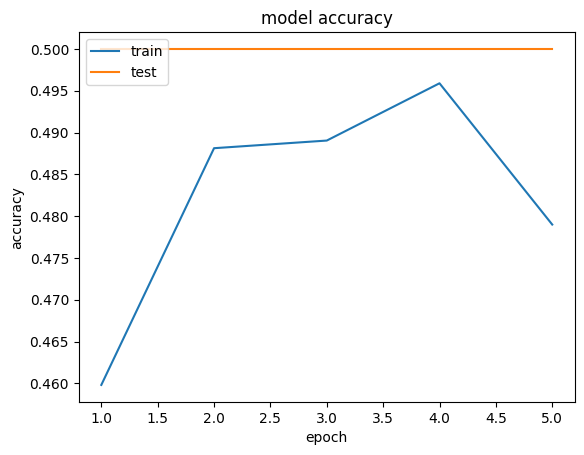

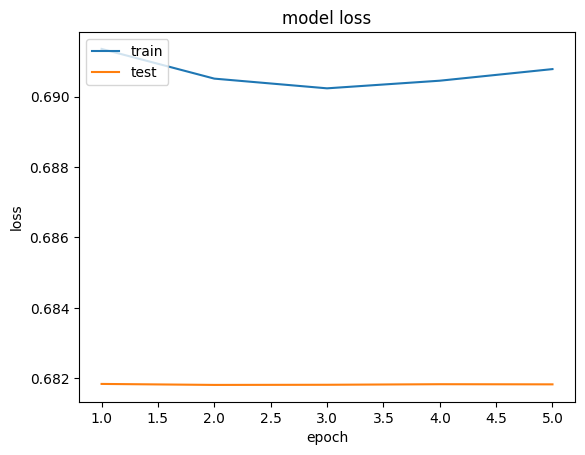

In [33]:
import matplotlib.pyplot as plt
import matplotlib as matplotlib

# NOTE: ONLY WORKS FOR MULTIPLE EPOCHS

# PLOT ACCURACY
plt.plot(range(1, EPOCHS + 1), history.history['accuracy'])
plt.plot(range(1, EPOCHS + 1, 1),history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# PLOT LOSS
plt.plot(range(1, EPOCHS + 1),history.history['loss'])
plt.plot(range(1, EPOCHS + 1),history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()